<a href="https://colab.research.google.com/github/aissam-out/Financial-Inclusion-in-Africa/blob/master/financial_inclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Resources

In [0]:
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
%matplotlib inline

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive #if needed
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Train data
downloaded_train = drive.CreateFile({'id':'****************'}) 
downloaded_train.GetContentFile('Train_v2.csv')

# Test data
downloaded_train = drive.CreateFile({'id':'****************'}) 
downloaded_train.GetContentFile('Test_v2.csv')

# Submission file
downloaded_train = drive.CreateFile({'id':'*****************'}) 
downloaded_train.GetContentFile('SubmissionFile.csv')

# Variable definitions
downloaded_train = drive.CreateFile({'id':'******************'}) 
downloaded_train.GetContentFile('VariableDefinitions.csv')

# loading the dataset
df_train = pd.read_csv("Train_v2.csv")
df_test = pd.read_csv("Test_v2.csv")
submission_file = pd.read_csv("SubmissionFile.csv")
variables = pd.read_csv("VariableDefinitions.csv")

In [0]:
data = df_train.copy()
test = df_test.copy()

# Engineering

In [0]:
data.head(1)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed


In [0]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
country                   23524 non-null object
year                      23524 non-null int64
uniqueid                  23524 non-null object
bank_account              23524 non-null object
location_type             23524 non-null object
cellphone_access          23524 non-null object
household_size            23524 non-null int64
age_of_respondent         23524 non-null int64
gender_of_respondent      23524 non-null object
relationship_with_head    23524 non-null object
marital_status            23524 non-null object
education_level           23524 non-null object
job_type                  23524 non-null object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


In [0]:
def prepare_data():
  d = data.copy()
  
  d['bank_account'] = d['bank_account'].replace({'No':0, 'Yes':1})
  
  d = pd.get_dummies(d, columns=['country', 'location_type', 'cellphone_access', 'gender_of_respondent', 
                                 'relationship_with_head', 'marital_status', 'education_level', 'job_type'])
  d = d.drop("uniqueid", axis=1)
  
  # we can determine what 'year' it is by knowing the 'country'
  d = d.drop("year", axis=1)
  
  # we have a skewed distribution for this variable. Lets try to make it look like a bit more Gaussian by applying log base 10
  d.age_of_respondent = d.age_of_respondent.apply(np.log10)
  d.household_size = d.household_size.apply(np.log10)
  
  # Feature engineering 2 : extra drops after xgb's feature importance
  d = d.drop(['education_level_Other/Dont know/RTA',
              'job_type_Dont Know/Refuse to answer',
              'job_type_No Income',
              'relationship_with_head_Other non-relatives',
              'relationship_with_head_Other relative'], 
             axis=1)
  
  # Stratification because we have an imbalanced dataset
  test_yes = d[d.bank_account==1].sample(frac=0.2)
  test_no  = d[d.bank_account==0].sample(frac=0.2)
  d = d.drop(test_yes.index, axis=0)
  d = d.drop(test_no.index, axis=0)
  test_set = shuffle(pd.concat([test_yes, test_no]))
  
  df_train_l = pd.DataFrame(d.bank_account)
  df_test_l = pd.DataFrame(test_set.bank_account)
  df_train_v = d.drop("bank_account", axis=1)
  df_test_v = test_set.drop("bank_account", axis=1)
  
  # for debuging
  look_at_me = df_train_v.copy()
  
  print('train_v :', df_train_v.shape)
  print('train_l :', df_train_l.shape)
  print('test_v :', df_test_v.shape)
  print('test_l :', df_test_l.shape)
  
  # convert train to values
  x_train = (df_train_v.values).astype('float32')
  x_train = preprocessing.scale(x_train)
  y_train = df_train_l.values.astype('float32')

  # convert test to values
  x_test = (df_test_v.values).astype('float32')
  x_test = preprocessing.scale(x_test)
  y_test = df_test_l.values.astype('float32')
  
  return x_train, y_train, x_test, y_test, look_at_me

In [0]:
x_train, y_train, x_test, y_test, l = prepare_data()

train_v : (18820, 34)
train_l : (18820, 1)
test_v : (4704, 34)
test_l : (4704, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were enc

In [0]:
l.head()

,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,cellphone_access_Yes,gender_of_respondent_Female,gender_of_respondent_Male,relationship_with_head_Child,relationship_with_head_Head of Household,relationship_with_head_Other non-relatives,relationship_with_head_Other relative,relationship_with_head_Parent,relationship_with_head_Spouse,marital_status_Divorced/Seperated,marital_status_Dont know,marital_status_Married/Living together,marital_status_Single/Never Married,marital_status_Widowed,education_level_No formal education,education_level_Other/Dont know/RTA,education_level_Primary education,education_level_Secondary education,education_level_Tertiary education,education_level_Vocational/Specialised training,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,0.477121,1.380211,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.698970,1.845098,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.698970,1.414973,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0.698970,1.531479,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.903090,1.414973,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


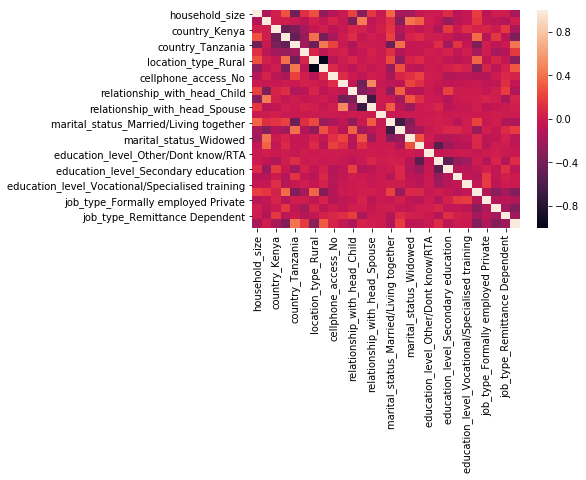

In [0]:
corr = l.corr()
ax = sns.heatmap(
    corr)

# Training

In [0]:
def zindi_model():
  
  model = xgb.XGBClassifier(min_child_weight= 2, 
                            max_depth=2, 
                            learning_rate= 0.1, 
                            gamma= 7, 
                            colsample_bytree= 0.8,
                            subsample=0.5,
                            n_estimators=50000,
                            objective='binary:hinge',
                            nthread=1)

  eval_set = [(x_train, y_train), (x_test, y_test)]

  model.fit(x_train, y_train, eval_metric='error', eval_set=eval_set, verbose=False)

  test_predictions = model.predict(x_test)
  test_acc = accuracy_score(y_test, test_predictions)
  train_predictions = model.predict(x_train)
  train_acc = accuracy_score(y_train, train_predictions)
  
  print("Train error :", 1-train_acc, ". Test error :", 1-test_acc)
  
  return model

In [0]:
# train the model
x_train, y_train, x_test, y_test, _ = prepare_data()
zindi_model = zindi_model()

# some results
# 0.118410 all features 70000 estim
# 0.111395 -5  features 70000 estim
# 0.107993 -5  features 40000 estim
# 0.109694 -5  features 20000 estim
# 0.108206 -5  features 50000 estim 3 max depth

train_v : (18820, 34)
train_l : (18820, 1)
test_v : (4704, 34)
test_l : (4704, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were enc

Train error : 0.10733262486716255 . Test error : 0.11054421768707479


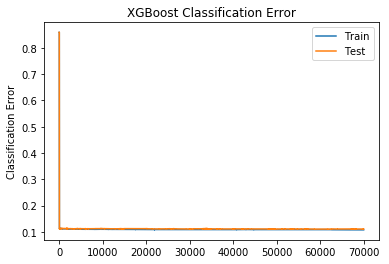

In [0]:
# retrieve performance metrics
results = zindi_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

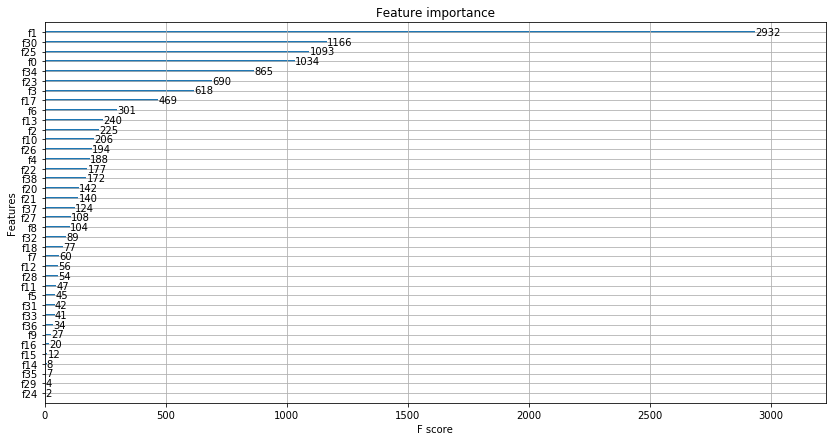

In [0]:
from xgboost import plot_importance

# plot feature importance
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(zindi_model)
plt.show()

In [0]:
# show columns names with their indexes
pd.DataFrame(l.columns).T.iloc[:,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,cellphone_access_Yes,gender_of_respondent_Female,gender_of_respondent_Male,relationship_with_head_Child,relationship_with_head_Head of Household,relationship_with_head_Other non-relatives,relationship_with_head_Other relative,relationship_with_head_Parent,relationship_with_head_Spouse,marital_status_Divorced/Seperated,marital_status_Dont know,marital_status_Married/Living together,marital_status_Single/Never Married,marital_status_Widowed,education_level_No formal education,education_level_Other/Dont know/RTA,education_level_Primary education,education_level_Secondary education,education_level_Tertiary education,education_level_Vocational/Specialised training,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed


In [0]:
# train another model using selected features 

from sklearn.feature_selection import SelectFromModel
thresh = 0.034

# select features using threshold
selection = SelectFromModel(zindi_model, threshold=thresh, prefit=True)
select_X_train = selection.transform(x_train)
select_X_train.shape

(18820, 12)

In [0]:
# train model
selection_model = xgb.XGBClassifier(min_child_weight= 2,
                                    max_depth= 2, 
                                    learning_rate= 0.1, 
                                    gamma= 9, 
                                    colsample_bytree= 0.8,
                                    subsample=0.5,
                                    n_estimators=50000,
                                    objective='binary:hinge',
                                    nthread=1)
selection_model.fit(select_X_train, y_train)

# eval model
select_X_test = selection.transform(x_test)
y_pred = selection_model.predict(select_X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
acc = accuracy_score(y_pred, y_test)
  
print("Error is : %f" %(1-acc))

Error is : 0.120323


# Save results

In [0]:
def prepare_submission(my_model):
  submission = submission_file.copy()
  test = df_test.copy()
  
  # prepare submission file
  submission = submission_file.drop('uniqueid', axis=1)
  submission.insert(loc=0, column='uniqueid', value=test['uniqueid'] + " x " + test['country'])
  
  # prepare test set
  test = pd.get_dummies(test, columns=['country', 'location_type', 'cellphone_access', 'gender_of_respondent', 
                                       'relationship_with_head', 'marital_status', 'education_level', 'job_type'])
  test = test.drop("uniqueid", axis=1)
  test = test.drop("year", axis=1)
  
  test.age_of_respondent = test.age_of_respondent.apply(np.log10)
  test.household_size = test.household_size.apply(np.log10)
  
  # Feature engineering 2 : extra drops 
  test = test.drop(['education_level_Other/Dont know/RTA',
                    'job_type_Dont Know/Refuse to answer',
                    'job_type_No Income',
                    'relationship_with_head_Other non-relatives',
                    'relationship_with_head_Other relative'], 
                  axis=1)

  # convert train to values
  test = (test.values).astype('float32')
  test = preprocessing.scale(test)
  
  # predict
  predictions_zindi = my_model.predict(test)
  results = pd.DataFrame(predictions_zindi)
  submission["bank_account"] = results
  submission.to_csv("submission_zindi.csv", header=True, index=False)
  
  %cp submission_zindi.csv gdrive/'My Drive'/'Colab Notebooks'/zindi

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
prepare_submission(zindi_model)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


# Post Train editing

Sometimes we need to edit few rows manually if we were able to detect some correlations in the EDA phase.

Here for example, very often Tanzanians without cellphones tend to not have a bank account.


In [0]:
# last submission
old_sub =  pd.read_csv("submission_zindi.csv")
sub = old_sub.copy()

# select indexes from the test set
data_inter = df_test[df_test.country=='Tanzania']
list_index1= data_inter[data_inter.cellphone_access=='No'].index

# editing
sub['bank_account'].loc[list_index1]=0.0

In [0]:
# check differeces between the two results
def dfDiff(oldFrame, newFrame):
	dfBool = (oldFrame != newFrame).stack()  
	diff = pd.concat([oldFrame.stack()[dfBool],
					  newFrame.stack()[dfBool]], axis=1)
	diff.columns=["Old", "New"]
	return diff

In [0]:
dfDiff(old_sub, sub).head(2)

,,Old,New
6459,bank_account,1,0
7338,bank_account,1,0


In [0]:
sub.to_csv("submission_zindi_new.csv", header=True, index=False)
%cp submission_zindi_new.csv gdrive/'My Drive'/'Colab Notebooks'/zindi